# Wire Cutting Phrased as a Two-Qubit `Move` Instruction

In this tutorial, we will reconstruct expectation values of a seven-qubit circuit by splitting it into two four-qubit circuits using wire cutting.

Like any circuit knitting technique, wire cutting can be described as three consecutive steps:

- **cut** some wires in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments using the Qiskit Sampler primitive
- **reconstruct** the expectation value of the full-sized circuit

### Create a circuit to cut

First, we begin with a circuit inspired by Fig. 1(a) of [arXiv:2302.03366v1](https://arxiv.org/abs/2302.03366v1).

In [1]:
import numpy as np
from qiskit import QuantumCircuit

qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

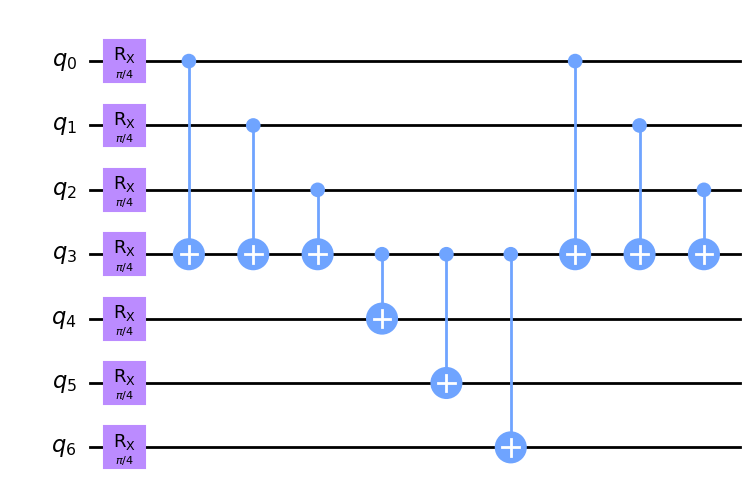

In [2]:
qc_0.draw("mpl")

### Specify some observables

Next, we specify a list of observables whose expectation values we would like to determine.

In [3]:
from qiskit.quantum_info import PauliList

observables_0 = PauliList(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

### Create a new circuit where `Move` instructions have been placed at the desired cut locations

Given the above circuit, we would like to place two wire cuts on the middle qubit line, so that the circuit can separate into two circuits of four qubits each.  One way to do this is to manually place two-qubit `Move` instructions that move the state from one qubit wire to another.  A `Move` instruction is conceptually equivalent to a reset operation on the second qubit, followed by a SWAP gate.  The effect of this instruction is to transfer the state of the first (source) qubit to the second (detination) qubit, while discarding the incoming state of the second qubit.  For this to work as intended, it is important that the second (destination) qubit share no entanglement with the remainder of the system; otherwise, the reset operation will cause the state of the remainder of the system to be partially collapsed.

Here, we build a new circuit with one additional qubit and the `Move` operations in place.  In this example, we are able to reuse a qubit: the source qubit of the first `Move` becomes the destination qubit of the second `Move` operation.

Note: As an alternative to working directly with `Move` instructions, one may choose to mark wire cuts using a single-qubit `CutWire` instruction.  The `cut_wires` function exists to transform `CutWire`s to `Move` instructions on newly allocated qubits.  However, in contrast to the manual method, this automatic method does not allow for the re-use of qubit wires.  See the `CutWire` [how-to guide](../how-tos/how_to_specify_cut_wires.ipynb) for details.

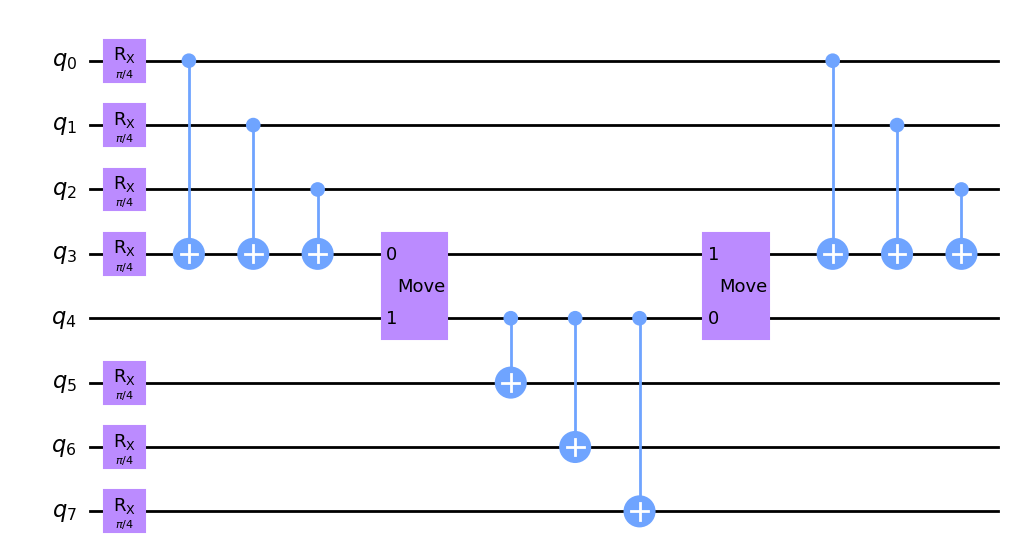

In [4]:
from circuit_knitting.cutting.instructions import Move

qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

qc_1.draw("mpl")

### Create observables to go with the new circuit

These observables correspond with `observables_0`, but we must account correctly for the extra qubit wire that has been added (i.e., we insert an "I" at index 4).  Note that in Qiskit, the string representation qubit-0 corresponds to the right-most Pauli character.

In [5]:
observables_1 = PauliList(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])

### Separate the circuit and observables

As in the previous tutorials, qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.

In [6]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_1, partition_labels="AAAABBBB", observables=observables_1
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

### Visualize the decomposed problem

In [7]:
subobservables

{'A': PauliList(['IIII', 'ZIII', 'IIIZ']),
 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

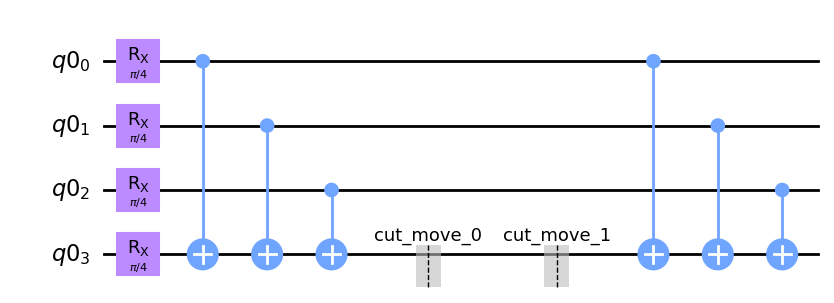

In [8]:
subcircuits["A"].draw("mpl")

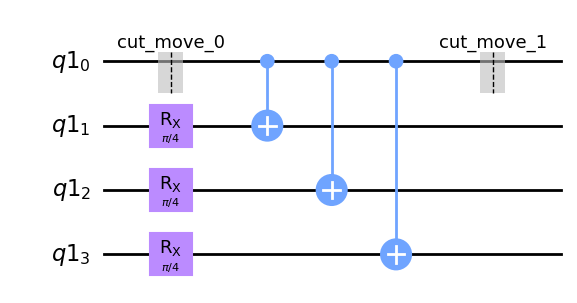

In [9]:
subcircuits["B"].draw("mpl")

### Calculate the sampling overhead for the chosen cuts

Here we cut two wires, resulting in a sampling overhead of $4^4$.

For more on the sampling overhead incurred by circuit cutting, refer to the [explanatory material](../explanation/index.rst).

In [10]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 256.0


### Generate the subexperiments to run on the backend

`generate_cutting_experiments` accepts `circuits`/`observables` args as dictionaries mapping qubit partition labels to the respective `subcircuit`/`subobservables`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](../explanation/index.rst).

In [11]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

### Run the subexperiments using the Qiskit Sampler primitive

In [12]:
from qiskit_aer.primitives import Sampler

# Set up a Qiskit Aer Sampler primitive for each circuit partition
samplers = {
    label: Sampler(run_options={"shots": 2**12}) for label in subexperiments.keys()
}

# Retrieve results from each partition's subexperiments
results = {
    label: sampler.run(subexperiments[label]).result()
    for label, sampler in samplers.items()
}

To use the Qiskit Runtime Sampler, replace the code above with this commented block.

In [13]:
# from qiskit_ibm_runtime import Session, Options, Sampler

# with Session(backend="ibmq_qasm_simulator") as session:
#     # Set up Qiskit Runtime Sampler primitives.
#     samplers = {
#         label: Sampler(Options(execution={"shots": 2**12})) for label in subexperiments.keys()
#     }
#
# Retrieve results from each subexperiment
#     results = {
#         label: sampler.run(subexperiments[label]).result()
#         for label, sampler in samplers.items()
#     }

#     session.close()

### Reconstruct the expectation values

Use the subexperiment results, subobservables, and sampling coefficients to reconstruct the expectation value of the original circuit.

In [14]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

### Compare the reconstructed expectation values with the exact expectation values from the original circuit

In [15]:
from qiskit_aer.primitives import Estimator

estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([qc_0] * len(observables_0), list(observables_0)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Reconstructed expectation values: [0.15630245, 0.68548346, 0.69142044]
Exact expectation values: [0.1767767, 0.70710678, 0.70710678]
Errors in estimation: [-0.02047424, -0.02162333, -0.01568635]
Relative errors in estimation: [-0.11581981, -0.03058, -0.02218384]
